In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [2]:
os.listdir("../data/data")

['node_cpu_seconds_total_2024-03-18 12:41:41.371912.csv',
 'kepler_node_dram_joules_total_2024-03-19 06:34:00.058204.csv',
 'node_cpu_seconds_total_2024-03-19 06:25:58.919617.csv',
 'kepler_node_platform_joules_total_2024-03-19 06:34:20.391305.csv',
 'kepler_node_core_joules_total_2024-03-19 06:23:46.282228.csv',
 'kepler_node_package_joules_total_2024-03-19 06:34:12.211429.csv',
 'kepler_node_other_joules_total_2024-03-19 06:34:23.164069.csv']

In [3]:
data_folder = "../data/data/"
cpu_util_file = "node_cpu_seconds_total_2024-03-19 06:25:58.919617.csv"
node_package_power_file =  'kepler_node_package_joules_total_2024-03-19 06:34:12.211429.csv'
node_dram_power_file =  'kepler_node_dram_joules_total_2024-03-19 06:34:00.058204.csv'

In [50]:
print(data_folder+cpu_util_file)
cpu_util = pd.read_csv(data_folder+cpu_util_file)
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

node_package_power = pd.read_csv(data_folder+node_package_power_file)
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(data_folder+node_dram_power_file)
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])


../data/data/node_cpu_seconds_total_2024-03-19 06:25:58.919617.csv


In [12]:
node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [42]:
node_power_metrics['instance'].unique()


array(['kube-master-90', 'kube-worker-68'], dtype=object)

In [11]:
import model

Node :  kube-master-90


/tmp/ipykernel_803883/1194587905.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


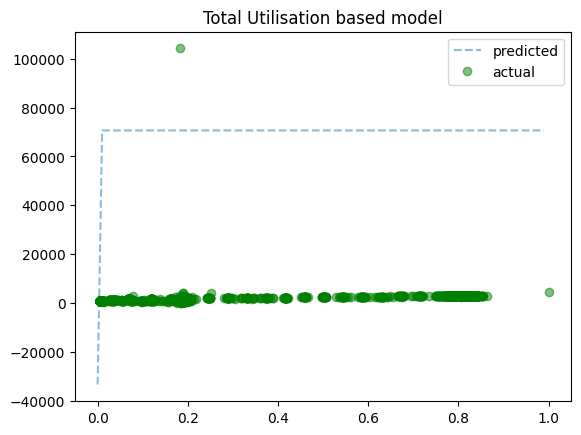

Node :  kube-worker-68


/tmp/ipykernel_803883/1194587905.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


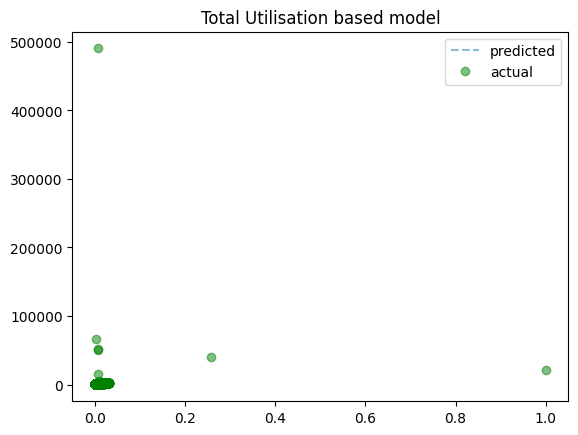

In [43]:
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']/3
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [54]:
cpu_util_agg[cpu_util_agg['instance']=='kube-worker-68']['value'].diff()

5645        NaN
5646       4.28
5647       4.80
5648       5.08
5649       5.09
          ...  
11220    563.00
11221    556.81
11222    567.09
11223    554.70
11224    556.64
Name: value, Length: 5580, dtype: float64

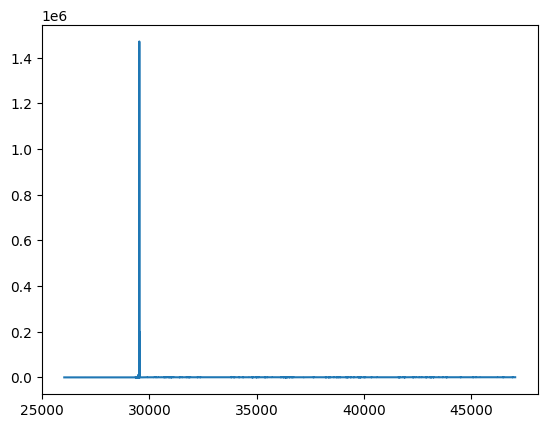

In [53]:
plt.plot(node_power_metrics[node_power_metrics['instance']=='kube-worker-68']['power'].diff()[4000:])

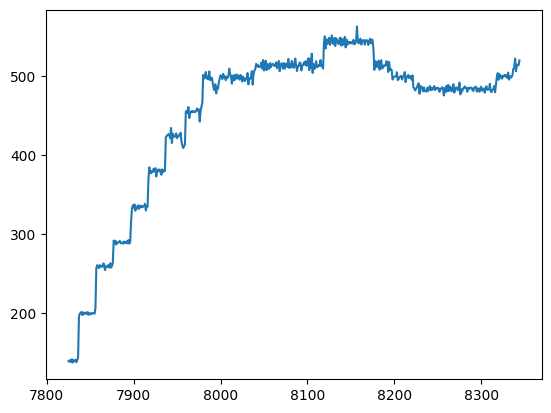

In [52]:
plt.plot(cpu_util_agg[cpu_util_agg['instance']=='kube-worker-68']['value'].diff()[2180:2700])

In [56]:
cpu_util_agg[cpu_util_agg['instance']=='kube-worker-68'].iloc[2180:2700]
#cpu_util_agg[cpu_util_agg['instance']=='kube-master-90'].iloc[2180:2700]

,instance,timestamp,value
7825,kube-worker-68,2024-03-18 16:13:59.227999926,3087240.57
7826,kube-worker-68,2024-03-18 16:14:14.227999926,3087379.37
7827,kube-worker-68,2024-03-18 16:14:29.227999926,3087520.34
7828,kube-worker-68,2024-03-18 16:14:44.227999926,3087658.58
7829,kube-worker-68,2024-03-18 16:14:59.227999926,3087800.52
...,...,...,...
8340,kube-worker-68,2024-03-18 18:22:44.227999926,3319573.93
8341,kube-worker-68,2024-03-18 18:22:59.227999926,3320088.52
8342,kube-worker-68,2024-03-18 18:23:14.227999926,3320602.27
8343,kube-worker-68,2024-03-18 18:23:29.227999926,3321116.14


In [66]:
cpu_util_agg_68 =cpu_util_agg[cpu_util_agg['instance']=='kube-worker-68'].iloc[2180:2700]
cpu_util_agg_90 =cpu_util_agg[cpu_util_agg['instance']=='kube-master-90'].iloc[2180:2700]

print(cpu_util_agg_90)
print(cpu_util_agg_68)

total_cpu_util_agg = pd.concat([cpu_util_agg_68,cpu_util_agg_90])

print(total_cpu_util_agg.iloc[900:1051])

            instance                     timestamp       value
2180  kube-master-90 2024-03-18 15:57:34.857000113  2005107.16
2181  kube-master-90 2024-03-18 15:57:49.857000113  2005128.69
2182  kube-master-90 2024-03-18 15:58:04.857000113  2005178.20
2183  kube-master-90 2024-03-18 15:58:19.857000113  2005232.42
2184  kube-master-90 2024-03-18 15:58:34.857000113  2005292.13
...              ...                           ...         ...
2695  kube-master-90 2024-03-18 18:06:19.857000113  2455620.06
2696  kube-master-90 2024-03-18 18:06:34.857000113  2457037.26
2697  kube-master-90 2024-03-18 18:06:49.857000113  2458460.17
2698  kube-master-90 2024-03-18 18:07:04.857000113  2459885.21
2699  kube-master-90 2024-03-18 18:07:19.857000113  2461327.75

[520 rows x 3 columns]
            instance                     timestamp       value
7825  kube-worker-68 2024-03-18 16:13:59.227999926  3087240.57
7826  kube-worker-68 2024-03-18 16:14:14.227999926  3087379.37
7827  kube-worker-68 2024-03-18

In [32]:
node_ed = node_power_metrics[node_power_metrics["timestamp"] > "2024-03-18 15:57:34.857000113" ]


In [33]:
node_f = node_ed[node_ed["timestamp"]< "2024-03-18 18:07:19.857000113" ]

In [67]:
print(cpu_util_agg['instance'].unique())

['kube-master-90' 'kube-worker-68']


Node :  kube-worker-68
instance_x                   kube-worker-68
timestamp     2024-03-18 16:14:29.227999926
util                               0.250457
instance_y                   kube-worker-68
package                        41906458.338
dram                           37637917.886
power                          79544376.224
energy                             3988.019
Name: 2, dtype: object
instance_x                   kube-worker-68
timestamp     2024-03-18 16:14:14.227999926
util                               0.246602
instance_y                   kube-worker-68
package                         41903694.63
dram                           37636693.575
power                          79540388.205
energy                             3994.482
Name: 1, dtype: object


/tmp/ipykernel_803883/4218678292.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


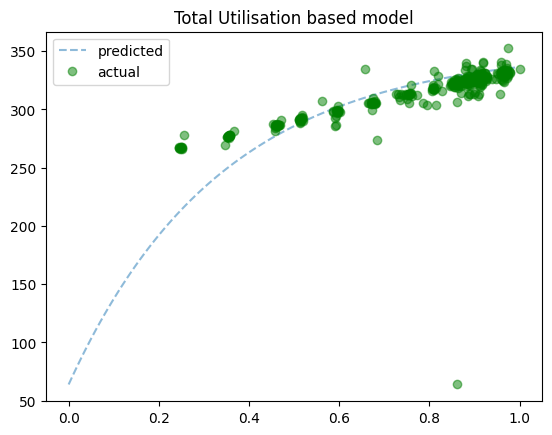

Node :  kube-master-90
instance_x                   kube-master-90
timestamp     2024-03-18 15:58:19.857000113
util                               0.036701
instance_y                   kube-master-90
package                         1779396.077
dram                            1512585.113
power                            3291981.19
energy                             3194.402
Name: 3, dtype: object
instance_x                   kube-master-90
timestamp     2024-03-18 15:58:04.857000113
util                               0.033512
instance_y                   kube-master-90
package                         1777634.069
dram                            1511152.719
power                           3288786.788
energy                              2724.32
Name: 2, dtype: object


/tmp/ipykernel_803883/4218678292.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


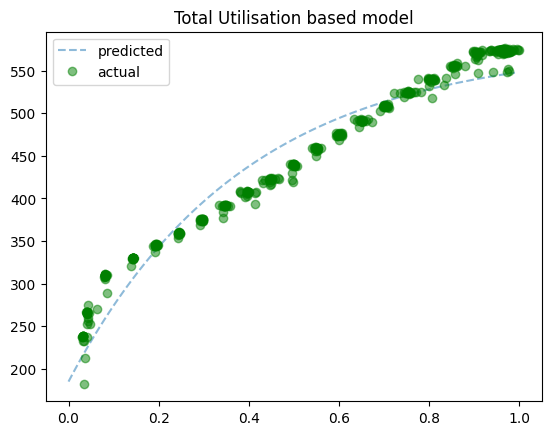

In [68]:

#Parul's version
node_power_models = {}
for node in total_cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = total_cpu_util_agg[total_cpu_util_agg['instance']==node]
    power = node_f[node_f['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    print( node_df.iloc[1])
    print( node_df.iloc[0])

    node_df['power'] = node_df['energy']/15
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])


In [73]:
#Parul's version

print(node_power_models['kube-worker-68'][2])

(tensor(351.4593, requires_grad=True), tensor(-287.5183, requires_grad=True), tensor(-2.9512, requires_grad=True))


Node :  kube-master-90
instance_x                   kube-master-90
timestamp     2024-03-18 15:58:19.857000113
util                               0.036701
instance_y                   kube-master-90
package                         1779396.077
dram                            1512585.113
power                            3291981.19
energy                             3194.402
Name: 3, dtype: object
instance_x                   kube-master-90
timestamp     2024-03-18 15:58:04.857000113
util                               0.033512
instance_y                   kube-master-90
package                         1777634.069
dram                            1511152.719
power                           3288786.788
energy                              2724.32
Name: 2, dtype: object


/tmp/ipykernel_803883/934634096.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


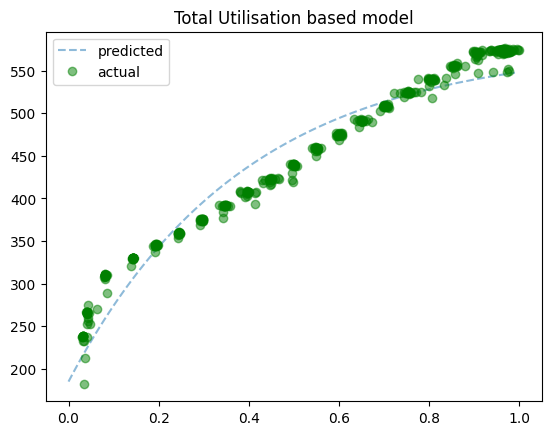

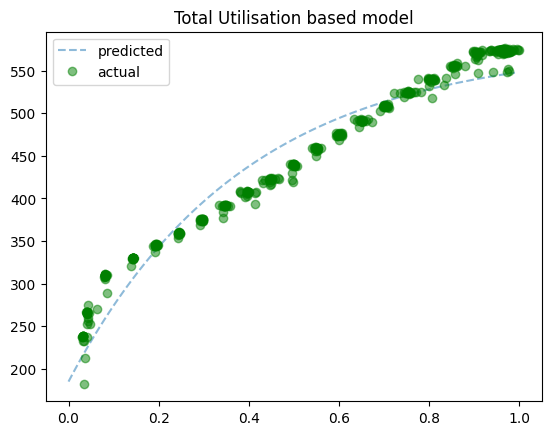

In [24]:

#Felix version
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_f[node_f['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    print( node_df.iloc[1])
    print( node_df.iloc[0])

    node_df['power'] = node_df['energy']/15
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])
